# Differencing between surveyed elevations and grain size properties

In [8]:
import numpy as np
# import pylab as plt
import matplotlib.pyplot as plt
from scipy import signal

In [9]:
# RTK
dn = "C:\\Projects\\AdvocateBeach2018\\data\\interim\\GPS\\"    
# fn = ["15_10_2018_A.txt", "16_10_2018_A.txt", "17_10_2018_A.txt", "18_10_2018_A.txt", "19_10_2018_A.txt",\
#       "20_10_2018_A.txt", "21_10_2018_A.txt", "21_10_2018_B.txt", "22_10_2018_A.txt", "22_10_2018_B.txt",\
#       "23_10_2018_A.txt", "23_10_2018_B.txt"]
fn = ["21_10_2018_B_longshore1.txt", "22_10_2018_A_longshore1.txt", "22_10_2018_B_longshore1.txt", \
      "23_10_2018_A_longshore1.txt", "23_10_2018_B_longshore1.txt", "24_10_2018_A_longshore1.txt", \
      "24_10_2018_B_longshore1.txt", "25_10_2018_A_longshore1.txt", "25_10_2018_B_longshore1.txt", \
      "26_10_2018_A_longshore1.txt", "26_10_2018_B_longshore1.txt", "27_10_2018_A_longshore1.txt", \
      "27_10_2018_B_longshore1.txt"]

# grid = [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
grid = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


# grain size
days = ["21_10_2018", "22_10_2018", "22_10_2018", "23_10_2018", "23_10_2018", "24_10_2018", \
        "24_10_2018", "25_10_2018", "25_10_2018", "26_10_2018", "26_10_2018", "27_10_2018", \
        "27_10_2018"]
tides = ["PM","AM","PM","AM","PM","AM","PM","AM","PM","AM","PM","AM","PM"]
grid_spec = "longshore1"

In [10]:
def import_RTK(fname, gridnum):
    
    with open(fname, 'rb') as f:
        clean_lines = ( line.replace(b'STK',b'').replace(b' ',b',') for line in f )
        data = np.genfromtxt(clean_lines,usecols=(0,1,2,3,4,),delimiter=',')

    # UTM coords of origin (Adv2015)
    originx = 3.579093296000000e+05;
    originy = 5.022719408400000e+06;

    northing = data[:,1] - originx
    easting = data[:,2] - originy
    elevation = data[:,3]
    stkID = data[:,4]
    
    # indices for each grid type
    Izl = []
    ILl = []
    Ida = []
    
    if gridnum == 1:
        zlineID = list(range(70,101))
        LlineID = list(range(284,360))

        # took me a while to figure out this indexing -- hang on to this
        for stk in stkID:
            if stk in zlineID:
                Izl.append(list(np.where(stkID==stk))[0][0])
            if stk in LlineID:
                ILl.append(list(np.where(stkID==stk))[0][0])
                
    elif gridnum == 2:     
    
        zlineID = list(range(145,175))
        LlineID = list(range(176,202))
        denseID = list(range(1,145))

        for stk in stkID:
            if stk in zlineID:
                Izl.append(list(np.where(stkID==stk))[0][0])
            if stk in LlineID:
                ILl.append(list(np.where(stkID==stk))[0][0])
            if stk in denseID:
                Ida.append(list(np.where(stkID==stk))[0][0]) 
                
    elif gridnum == 3:     
    
        LlineID = list(range(176,202))

        for stk in stkID1:
            if stk in LlineID:
                ILl.append(list(np.where(stkID==stk))[0][0])      
    
    zline = (northing[Izl], easting[Izl], elevation[Izl])
    longshore = (northing[ILl], easting[ILl], elevation[ILl])
    dense_array = (northing[Ida], easting[Ida], elevation[Ida])
            
    return zline, longshore, dense_array     


In [11]:
def gsize_stats(fname):

    import csv

    with open(fname, 'rt') as f:

        readCSV = csv.reader(f, delimiter=',')
        skewness = []
        mean_gsize = []
        percentiles = []
        percentile_vals = []
        gsize_freqs = []
        gsize_bins = []
        sorting = []
        kurtosis = []

        for col in readCSV:

            skewness.append(col[0])
            mean_gsize.append(col[1])
            percentiles.append(col[2])
            percentile_vals.append(col[3])
            gsize_freqs.append(col[4])
            gsize_bins.append(col[5])
            sorting.append(col[6])
            kurtosis.append(col[7])
            
        return skewness, mean_gsize, percentiles, percentile_vals, gsize_freqs, gsize_bins, sorting, kurtosis


In [12]:
def reformat_gsize_stats(day,tide,grid_specs):

    import glob

    dn = "C:\\Projects\\AdvocateBeach2018\\data\\processed\\grainsize_dists\\" \
        + day + "\\" + tide + "\\" + grid_specs + "\\"

    skew_vec = []
    mean_gsize_vec = []
    sort_vec = []
    kurt_vec = []

    for fname in glob.glob(dn + '*.csv'):

        skewness, mean_gsize, percentiles, percentile_vals, gsize_freqs, gsize_bins, sorting, kurtosis = gsize_stats(fname)

        skew_vec.append(float(skewness[1]))
        mean_gsize_vec.append(float(mean_gsize[1]))
        sort_vec.append(float(sorting[1]))
        kurt_vec.append(float(kurtosis[1]))
        
    return mean_gsize_vec, sort_vec, skew_vec, kurt_vec

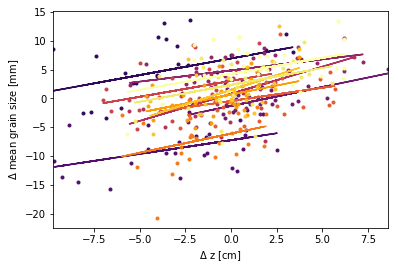

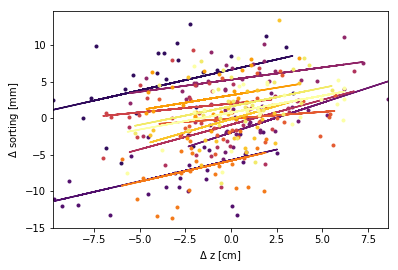

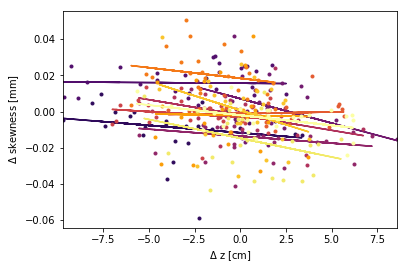

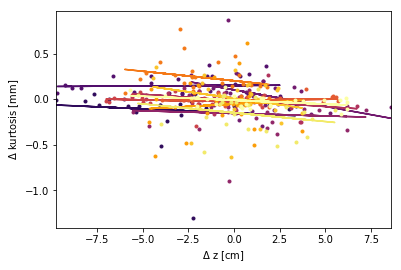

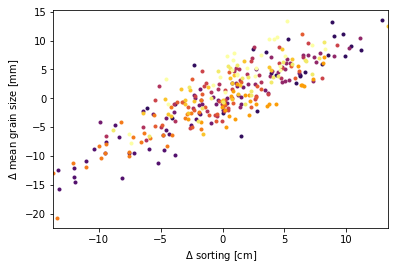

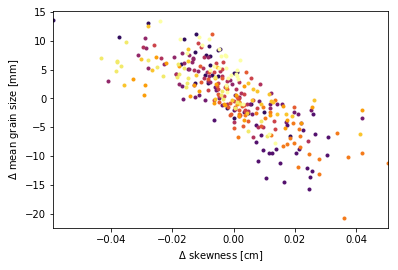

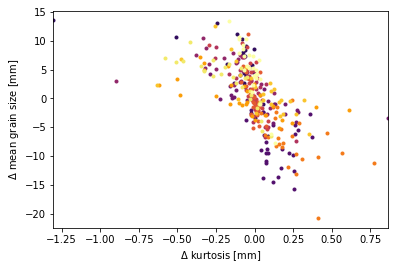

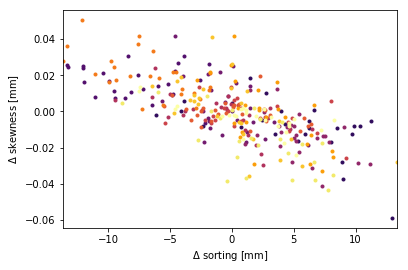

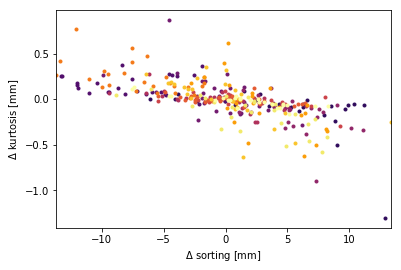

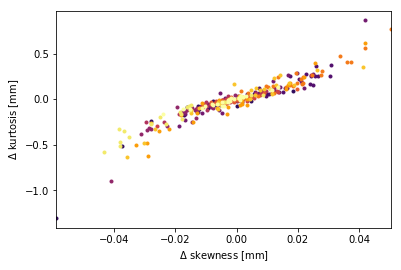

In [16]:
# compute morpho- and sedimentological differences and plot

dgsize_vec = []
dz_vec = []

for m in range(0, len(fn)):
    
    # for differencing
    if m > 0:
        last_tide = np.copy(coords)
        last_mean_gsize_vec = np.copy(mean_gsize_vec)
        last_sort_vec = np.copy(sort_vec)
        last_skew_vec = np.copy(skew_vec)
        last_kurt_vec = np.copy(kurt_vec)
    
    coords = import_RTK(dn+fn[m], grid[m])
    mean_gsize_vec, sort_vec, skew_vec, kurt_vec = reformat_gsize_stats(days[m], tides[m], grid_spec)

    # NB: coords[zl,Ll,da][x,y,z]

    if m > 0:
        
        # longshore line
        
        # tide-tide difference: RTK
        dz_a = coords[1][2] - last_tide[1][2]
#         dz_a = signal.detrend(coords[1][2] - last_tide[1][2])
        east_a = coords[1][1]
        
        # tide-tide difference: grain size
        dgs_a = mean_gsize_vec - last_mean_gsize_vec
#         dgs_a = signal.detrend(mean_gsize_vec - last_mean_gsize_vec)
    
        dsort_a = sort_vec - last_sort_vec
        dskew_a = skew_vec - last_skew_vec
        dkurt_a = kurt_vec - last_kurt_vec
        
        # linear regressions
        ft_mgs = np.polyfit(dz_a, dgs_a, 1)
        ft_sort = np.polyfit(dz_a, dsort_a, 1)
        ft_skew = np.polyfit(dz_a, dskew_a, 1)
        ft_kurt = np.polyfit(dz_a, dkurt_a, 1)
        
        # try some correlations
        xcorr_gsize_gsize = signal.correlate(signal.detrend(mean_gsize_vec), signal.detrend(last_mean_gsize_vec), mode='full', method='auto')
#         lag = np.argmax(signal.correlate(signal.detrend(mean_gsize_vec), signal.detrend(last_mean_gsize_vec)))
#         plt.figure()
#         plt.plot(xcorr_gsize_gsize)
        
        #     plt.figure(1)
        #     plt.plot(coords[0][0], coords[0][2])

        #     plt.figure(2)
        #     plt.plot(coords[1][0], coords[1][2])
        
#         plt.figure(3)
#         plt.plot(east_a, dz_a)

#         plt.figure(4)
#         plt.plot(east_a, dgs_a)

        clr = plt.cm.inferno(20+m*20)
        
        # morphology vs mean grain size
        plt.figure(5)
#         plt.subplot(221)
        plt.plot(dz_a*100, dgs_a, '.', color=clr)
#         plt.plot(dz_a*100, dgs_a, '.')
        plt.plot(dz_a*100, (ft_mgs[0]*dz_a + ft_mgs[1]), color=clr)
    
        # morphology vs sorting
        plt.figure(6)
#         plt.subplot(222)
        plt.plot(dz_a*100, dsort_a, '.', color=clr)
        plt.plot(dz_a*100, (ft_sort[0]*dz_a + ft_sort[1]), color=clr)
    
        # morphology vs skewness
        plt.figure(7)
#         plt.subplot(223)
        plt.plot(dz_a*100, dskew_a, '.', color=clr)
        plt.plot(dz_a*100, (ft_skew[0]*dz_a + ft_skew[1]), color=clr)
        
        # morphology vs kurtosis
        plt.figure(8)
#         plt.subplot(224)
        plt.plot(dz_a*100, dkurt_a, '.', color=clr)
        plt.plot(dz_a*100, (ft_kurt[0]*dz_a + ft_kurt[1]), color=clr)
        
        # sorting vs mean grain size
        plt.figure(9)
        plt.plot(dsort_a, dgs_a, '.', color=clr)
        
        # swekness vs mean grain size
        plt.figure(10)
        plt.plot(dskew_a, dgs_a, '.', color=clr)
        
        # kurtosis vs mean grain size
        plt.figure(11)
        plt.plot(dkurt_a, dgs_a, '.', color=clr)
        
        # sorting vs skewness
        plt.figure(12)
        plt.plot(dsort_a, dskew_a, '.', color=clr)
        
        # sorting vs kurtosis
        plt.figure(13)
        plt.plot(dsort_a, dkurt_a, '.', color=clr)
        
        # skewness vs kurtosis
        plt.figure(14)
        plt.plot(dskew_a, dkurt_a, '.', color=clr)
        
    
plt.figure(5)
# plt.subplot(221)
plt.xlabel('$\Delta$ z [cm]')
plt.ylabel('$\Delta$ mean grain size [mm]')
plt.autoscale(enable=True, axis='x', tight=True)

plt.figure(6)
# plt.subplot(222)
plt.xlabel('$\Delta$ z [cm]')
plt.ylabel('$\Delta$ sorting [mm]')
plt.autoscale(enable=True, axis='x', tight=True)

plt.figure(7)
# plt.subplot(223)
plt.xlabel('$\Delta$ z [cm]')
plt.ylabel('$\Delta$ skewness [mm]')
plt.autoscale(enable=True, axis='x', tight=True)
    
plt.figure(8)
# plt.subplot(224)
plt.xlabel('$\Delta$ z [cm]')
plt.ylabel('$\Delta$ kurtosis [mm]')
plt.autoscale(enable=True, axis='x', tight=True)

plt.figure(9)
plt.xlabel('$\Delta$ sorting [cm]')
plt.ylabel('$\Delta$ mean grain size [mm]')
plt.autoscale(enable=True, axis='x', tight=True)

plt.figure(10)
plt.xlabel('$\Delta$ skewness [cm]')
plt.ylabel('$\Delta$ mean grain size [mm]')
plt.autoscale(enable=True, axis='x', tight=True)

plt.figure(11)
plt.xlabel('$\Delta$ kurtosis [mm]')
plt.ylabel('$\Delta$ mean grain size [mm]')
plt.autoscale(enable=True, axis='x', tight=True)

plt.figure(12)
plt.xlabel('$\Delta$ sorting [mm]')
plt.ylabel('$\Delta$ skewness [mm]')
plt.autoscale(enable=True, axis='x', tight=True)

plt.figure(13)
plt.xlabel('$\Delta$ sorting [mm]')
plt.ylabel('$\Delta$ kurtosis [mm]')
plt.autoscale(enable=True, axis='x', tight=True)

plt.figure(14)
plt.xlabel('$\Delta$ skewness [mm]')
plt.ylabel('$\Delta$ kurtosis [mm]')
plt.autoscale(enable=True, axis='x', tight=True)

# plt.figure(1)
# plt.xlabel('easting [m]')
# plt.ylabel('elevation [m]')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.show()   

# plt.figure(2)
# plt.xlabel('easting [m]')
# plt.ylabel('elevation [m]')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.show()

# plt.figure(3)
# plt.xlabel('easting [m]')
# plt.ylabel('\delta elevation [m]')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.show()  

# plt.figure(4)
# plt.xlabel('easting [m]')
# plt.ylabel('\delta grain size [m]')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.show()  

In [14]:
lag

NameError: name 'lag' is not defined